In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler
from pprint import pprint
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_context('notebook')
sns.set_style(style='darkgrid')
%matplotlib inline

In [2]:
#import xgboost as xgb
#from xgboost import XGBClassifier
#print ('XGBoost v', xgb.__version__)


In [3]:
def get_roc(y_test, y_pred):
    #Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics')
    plt.legend(loc='upper left')
    plt.show()
    return



In [4]:
data = pd.read_csv('C:\Harinee\Projects\Capstone inference\Data\creditcard.csv')
data.head(10)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [5]:
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)


In [6]:
def drawConfusionMatrix(cnf_matrix):
    print(cnf_matrix)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [7]:
#This displays a sample confusion matrix and ROC
def analyzePredictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    #------------------------------
    drawConfusionMatrix(cnf_matrix)
    #-----------------------------------------
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    #------------------------------------------
    y_pred_proba = model.predict_proba(X_test)[:,1]
    get_roc(y_test, y_pred_proba)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[56860    15]
 [   35    52]]
Accuracy: 0.9991222218320986
Precision: 0.7761194029850746
Recall: 0.5977011494252874


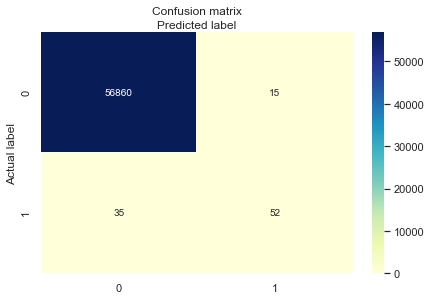

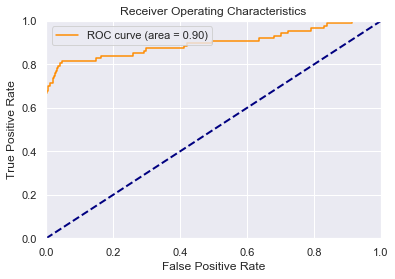

In [8]:
model = LogisticRegression()
model.fit(X_train,y_train)
analyzePredictions(model, X_test, y_test)


In [9]:
#Tuning with multiple C values
tuned_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:

{'C': 1000}

Grid scores on development set:

0.924 (+/-0.033) for {'C': 0.001}
0.896 (+/-0.044) for {'C': 0.01}
0.925 (+/-0.027) for {'C': 0.1}
0.921 (+/-0.039) for {'C': 1}
0.926 (+/-0.035) for {'C': 10}
0.899 (+/-0.050) for {'C': 100}
0.927 (+/-0.035) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.80      0.59      0.68        87

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.90      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962


# Tuning hyper-parameters for recall



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:

{'C': 100}

Grid scores on development set:

0.742 (+/-0.056) for {'C': 0.001}
0.785 (+/-0.084) for {'C': 0.01}
0.806 (+/-0.043) for {'C': 0.1}
0.816 (+/-0.036) for {'C': 1}
0.823 (+/-0.024) for {'C': 10}
0.831 (+/-0.070) for {'C': 100}
0.825 (+/-0.015) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.80      0.59      0.68        87

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.90      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962




Logistic Regression
[[56854    21]
 [   35    52]]


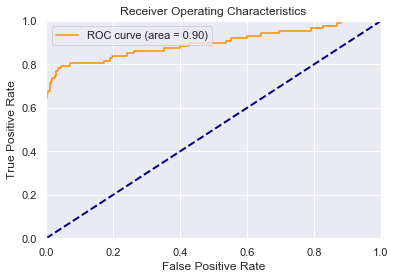

In [10]:
#Logistic Regression
#Use Logistic Regression using the train data, then compute the confusion matrix and the AUC.
from sklearn.linear_model import LogisticRegression
print ("Logistic Regression")
def logregclf(X_train, y_train, X_test, y_test):
    model = LogisticRegression(solver='lbfgs', max_iter=500, C=10).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    y_pred_proba = model.predict_proba(X_test)[:,1]
    get_roc(y_test, y_pred_proba)
    return
logregclf(X_train, y_train, X_test, y_test)